In [1]:
SEED = 61

import os
import re
import gc
import h5py
import torch
import numpy as np
import pandas as pd
import tensorflow as tf
import random as python_random
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

from tqdm import tqdm
from nltk import tokenize
from collections import Counter
from IPython.display import display_html
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from transformers import BertTokenizer, BertForMaskedLM, BertModel
from tensorflow.python.keras.layers import Layer, InputSpec, Lambda

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import RepeatedKFold, KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

from keras import backend as K
from keras import initializers, regularizers, constraints
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Reshape, Input, Embedding, Flatten, Dense, Dropout, BatchNormalization, Activation #, merge
from keras.layers import TimeDistributed, LSTM, GRU, Bidirectional, Convolution1D, MaxPooling1D, MaxPooling2D, Concatenate, Attention
from keras.layers.core import RepeatVector #, Reshape
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential, Model, load_model
from keras.optimizer_v2 import adam

def reset_seeds():
    np.random.seed(SEED) 
    python_random.seed(SEED)
    tf.random.set_seed(SEED)
    os.environ["PYTHONHASHSEED"] = str(SEED)

In [2]:
def read_hdf5(path):
    read_file = h5py.File(path, 'r')
    
    feature_names = list(read_file.keys())
    loaded_data = []
    
    for name in feature_names:
        dataset = read_file[name][:]
        if dataset.dtype == np.dtype('object'):
            dataset = np.array([x.decode('UTF-8') for x in dataset])            
        loaded_data.append((name, dataset))

    return loaded_data

def loadz(path):
    data = np.load(path)['arr_0']
    return data

def load_labels(path):
    data = read_hdf5(path)

    for x in data:
        if x[0] == 'multimodal-labels':
            labels = x[1]
        if x[0] == 'text-labels':
            text_labels = x[1]
        if x[0] == 'image-labels':
            image_labels = x[1]
        
    return labels, text_labels, image_labels

def merge_mvsa(mvsa_single, mvsa_multiple):
    mvsa = np.concatenate((mvsa_single, mvsa_multiple), axis=0)
    return mvsa

def load_mvsa_feature(feature_name, merge=False):
    folder_path = os.path.join('../input/mvsa-features/', feature_name)
    single_file = 'mvsa-single-{}.npz'.format(feature_name)
    multiple_file = 'mvsa-multiple-{}.npz'.format(feature_name)
    mvsa_single = loadz(os.path.join(folder_path, single_file))
    mvsa_multiple = loadz(os.path.join(folder_path, multiple_file))
    
    if merge == True:
        return merge_mvsa(mvsa_single, mvsa_multiple)
    
    return mvsa_single, mvsa_multiple

def merge_dim(*args):
    return np.concatenate(args, axis=1)

# e.g. validation_split=0.1 -----> 8:1:1 ratio of train, val, test
def split_data(data, validation_split):
    num_val = int(validation_split * data.shape[0])
    data_train = data[:-(num_val*2)]
    data_val = data[-(num_val*2):-(num_val)]
    data_test = data[-num_val:]
    return data_train, data_val, data_test

In [3]:
def weighted_average(weights, probs):
    ''' Calculate the weighted average probability distribution from all input probs and its weights 
    weights: weights list (or array)
    probs: probability distributions array list
    '''
    output_probs = []
    weighted_probs = [probs[i] * weights[i] for i in range(len(weights))]
    for i in range(len(probs[0])):
        sum_prob = np.zeros(len(probs[0][0]))
        for j in range(len(weights)):
            sum_prob = np.sum((sum_prob, weighted_probs[j][i]), axis=0)
        output_probs.append(sum_prob)
    return np.asarray(output_probs, dtype='float32')

def get_average_weights(*scores, inverse=False):
    ''' Get the corresponding weight of each input score 
    inverse: (bool) get inverse weights value in case of the smaller score value, the bigger weight value (such as model loss)
    '''
    
    weights = []
    for score in scores:
        weights.append(score/np.sum(scores))

    if inverse == True:
        inverse_weights = []
        inverse = [1/weight for weight in weights]
        for inv in inverse:
            inverse_weights.append(inv/np.sum(inverse))
        weights = inverse_weights

    return weights

In [4]:
def create_model_text(input_shape, lstm=True):
    text_input = Input(shape=input_shape)
    if lstm == True:
        reshape_text = Reshape((1, -1)) (text_input)
        lstm = LSTM(NUM_LSTM) (reshape_text)
        outputs = Dense(NUM_CLASSES, activation='softmax') (lstm)
    else:
        outputs = Dense(NUM_CLASSES, activation='softmax') (text_input)
    model = Model(text_input, outputs)
    model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)
    return model

def create_model_image(input_shape):
    image_input = Input(shape=input_shape)
    outputs = Dense(NUM_CLASSES, activation='softmax') (image_input)
    model = Model(image_input, outputs)
    model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)
    return model

def create_model_IF(text_shape, image_shape, lstm=True):
    image_input = Input(shape=image_shape)
    text_input = Input(shape=text_shape)
    if lstm == True:
        text_reshape = Reshape((1, -1)) (text_input)
        text_lstm = LSTM(NUM_LSTM) (text_reshape)
#     text_lstm = Dropout(DROPOUT_RATE) (text_lstm)
        text_image_concat = Concatenate(axis=1)([text_lstm, image_input])
    else:
        text_image_concat = Concatenate(axis=1)([text_input, image_input])
    concat_self_attention = Attention() ([text_image_concat, text_image_concat])
#     concat_self_attention = Dropout(DROPOUT_RATE) (concat_self_attention)
    outputs = Dense(NUM_CLASSES, activation='softmax') (concat_self_attention)
    model = Model([text_input, image_input], outputs)
    model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)
    return model

In [5]:
def run_and_evaluate_HF(name, X1, X2, y, verbose=0, lstm=True):
    ''' Train Hybrid Fusion model and test only with Multimodal Labels
    X1: text input
    X2: image input
    y: labels
    verbose: 0 or 1 to print tracking on progress
    '''
    y = le.transform(y)
    y = to_categorical(np.asarray(y))
    
    random_idx = np.random.permutation(len(label_inputs))
    X1, X2, y = X1[random_idx], X2[random_idx], y[random_idx]
    
    X1_train, X1_val, X1_test = split_data(X1, VALIDATION_SPLIT)
    X2_train, X2_val, X2_test = split_data(X2, VALIDATION_SPLIT)
    y_train, y_val, y_test = split_data(y, VALIDATION_SPLIT)
    
    oversample = BorderlineSMOTE(sampling_strategy='minority', random_state=SEED, kind='borderline-2')
#     oversample = SMOTE(sampling_strategy='minority', random_state=SEED)
    X1_train, _ = oversample.fit_resample(X1_train, y_train)
    X2_train, y_train = oversample.fit_resample(X2_train, y_train)

    
    if lstm == False:
        model_text = create_model_text(X1_train.shape[1:], lstm=False)
        model_IF = create_model_IF(X1_train.shape[1:], X2_train.shape[1:], lstm=False)
    model_text = create_model_text(X1_train.shape[1:])
    model_IF = create_model_IF(X1_train.shape[1:], X2_train.shape[1:])
    model_image = create_model_image(X2_train.shape[1:])

    early_stopping1 = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=EARLY_STOPPING)
    early_stopping2 = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=EARLY_STOPPING)
    early_stopping3 = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=EARLY_STOPPING)

    checkpoint_text = ModelCheckpoint('./model_checkpoint/{}-text.h5'.format(name), save_best_only=True, verbose=verbose)
    checkpoint_image = ModelCheckpoint('./model_checkpoint/{}-image.h5'.format(name), save_best_only=True, verbose=verbose)
    checkpoint_IF = ModelCheckpoint('./model_checkpoint/{}-IF.h5'.format(name), save_best_only=True, verbose=verbose)

    if 'multiple' in name:
        batch_size = 256
    else:
        batch_size = BATCH_SIZE # 128
    
    history_text = model_text.fit(X1_train, y_train, validation_data=(X1_val, y_val), 
                        epochs=EPOCHS, batch_size=batch_size, verbose=verbose,
                        callbacks=[checkpoint_text, early_stopping1])
    
    history_image = model_image.fit(X2_train, y_train, validation_data=(X2_val, y_val), 
                        epochs=EPOCHS, batch_size=batch_size, verbose=verbose,
                        callbacks=[checkpoint_image, early_stopping2])
    
    history_IF = model_IF.fit([X1_train, X2_train], y_train, validation_data=([X1_val, X2_val], y_val), 
                        epochs=EPOCHS, batch_size=batch_size, verbose=verbose,
                        callbacks=[checkpoint_IF, early_stopping3])
    
    best_val_acc_text = np.min(history_text.history['val_accuracy'])
    best_val_acc_image = np.min(history_image.history['val_accuracy'])
    best_val_acc_IF = np.min(history_IF.history['val_accuracy'])
    
    weights = get_average_weights(best_val_acc_text, best_val_acc_image, best_val_acc_IF)

    model_text = load_model('./model_checkpoint/{}-text.h5'.format(name))
    model_image = load_model('./model_checkpoint/{}-image.h5'.format(name))
    model_IF = load_model('./model_checkpoint/{}-IF.h5'.format(name))

    y_pred_text = model_text.predict(X1_test)
    y_pred_image = model_image.predict(X2_test)
    y_pred_IF = model_IF.predict([X1_test, X2_test])
    
    y_pred = weighted_average(weights, np.asarray([y_pred_text, y_pred_image, y_pred_IF], dtype='float32'))
    
    best_epoch_text = np.argmin(history_text.history['val_loss'])
    best_epoch_image = np.argmin(history_image.history['val_loss'])
    best_epoch_IF = np.argmin(history_IF.history['val_loss'])
    
    if verbose == 1:
        print('Checkpoint of text model loaded at epoch:', best_epoch_text)
        print('Checkpoint of image model loaded at epoch:', best_epoch_image)
        print('Checkpoint of IF model loaded at epoch:', best_epoch_IF)

    return evaluate_model_LF(y_test, y_pred, verbose=verbose)

In [6]:
def evaluate_model_LF(y_true, y_pred, verbose=0):
    
    y_pred = le.inverse_transform(y_pred.argmax(axis=1))
    y_true = le.inverse_transform(y_true.argmax(axis=1))

    acc = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')

#     if verbose == 1:
    print(classification_report(y_true, y_pred))
    matrix = confusion_matrix(y_true, y_pred,
                              labels=list(le.classes_))
    cm_disp = ConfusionMatrixDisplay(confusion_matrix=matrix,
                              display_labels=list(le.classes_))
    cm_disp.plot()
    plt.show()

    return acc, f1_macro, f1_weighted

In [7]:
def plot_metrics(history):
    fig = plt.figure(figsize=(20, 5))

    fig.add_subplot(1, 4, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('LOSS')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='best')

    fig.add_subplot(1, 4, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('ACCURACY')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='best')

    fig.add_subplot(1, 4, 3)
    plt.plot(history.history['f1_macro'])
    plt.plot(history.history['val_f1_macro'])
    plt.title('Macro F1-SCORE')
    plt.ylabel('f1-macro')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='best')
    
    fig.add_subplot(1, 4, 4)
    plt.plot(history.history['f1_weighted'])
    plt.plot(history.history['val_f1_weighted'])
    plt.title('Weighted F1-SCORE')
    plt.ylabel('f1-weighted')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='best')

    plt.show()

# Load Data

In [8]:
## Choose best
# Load text feature
mvsa_single_bert, mvsa_multiple_bert = load_mvsa_feature('bert-base')
mvsa_single_pos_bow, mvsa_multiple_pos_bow = load_mvsa_feature('pos-bow')
mvsa_single_pos_tfidf, mvsa_multiple_pos_tfidf = load_mvsa_feature('pos-tfidf')
mvsa_single_ner_bow, mvsa_multiple_ner_bow = load_mvsa_feature('ner-bow')
mvsa_single_ner_tfidf, mvsa_multiple_ner_tfidf = load_mvsa_feature('ner-tfidf')

## Load image feature
# mvsa_single_vgg16, mvsa_multiple_vgg16 = load_mvsa_feature('vgg16')
mvsa_single_vgg19, mvsa_multiple_vgg19 = load_mvsa_feature('vgg19')
# mvsa_single_resnet50, mvsa_multiple_resnet50 = load_mvsa_feature('resnet50')
# mvsa_single_resnet101, mvsa_multiple_resnet101 = load_mvsa_feature('resnet101')
# mvsa_single_resnet152, mvsa_multiple_resnet152 = load_mvsa_feature('resnet152')
mvsa_single_densenet121, mvsa_multiple_densenet121 = load_mvsa_feature('densenet121')
# mvsa_single_densenet169, mvsa_multiple_densenet169 = load_mvsa_feature('densenet169')
mvsa_single_densenet201, mvsa_multiple_densenet201 = load_mvsa_feature('densenet201')

In [9]:
mvsa_single_multimodal_labels, mvsa_single_text_labels, mvsa_single_image_labels = load_labels('../input/mvsa-features/labels/mvsa-single-labels.hdf5')
mvsa_multiple_multimodal_labels, mvsa_multiple_text_labels, mvsa_multiple_image_labels = load_labels('../input/mvsa-features/labels/mvsa-multiple-labels.hdf5')

le = preprocessing.LabelEncoder()
le.fit(mvsa_multiple_multimodal_labels)

LabelEncoder()

In [10]:
import pickle
pickle.dump(le, open('label_encoder.pkl', 'wb'))
# le_loaded = pickle.load(open('label_encoder.pkl', 'rb'))

In [11]:
# from imblearn.over_sampling import RandomOverSampler
# ros = RandomOverSampler(random_state=SEED)
# X_resampled, y_resampled = ros.fit_resample(image_inputs, y)
# from collections import Counter
# print(sorted(Counter(y_resampled).items()))

# Model Training

In [12]:
reset_seeds()
EPOCHS = 100
BATCH_SIZE = 128
EARLY_STOPPING = 10
NUM_LSTM = 64
DROPOUT_RATE = 0.2
VALIDATION_SPLIT = 0.1
VERBOSE = 0

NUM_CLASSES = 3
f1_macro = tfa.metrics.F1Score(num_classes=NUM_CLASSES, average='macro', name='f1_macro')
f1_weighted = tfa.metrics.F1Score(num_classes=NUM_CLASSES, average='weighted', name='f1_weighted')
METRICS = ['accuracy', f1_macro, f1_weighted]
LOSS = 'categorical_crossentropy'
OPTIMIZER = 'adam'

2022-07-13 17:37:54.569947: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-13 17:37:54.571024: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-13 17:37:54.571802: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-13 17:37:54.572765: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

MVSA-Single: Counter({'positive': 2683, 'negative': 1358, 'neutral': 470})


2022-07-13 17:38:00.929292: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-07-13 17:38:03.330873: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


              precision    recall  f1-score   support

    negative       0.70      0.26      0.37       137
     neutral       0.45      0.30      0.36        50
    positive       0.67      0.94      0.78       264

    accuracy                           0.66       451
   macro avg       0.61      0.50      0.51       451
weighted avg       0.66      0.66      0.61       451



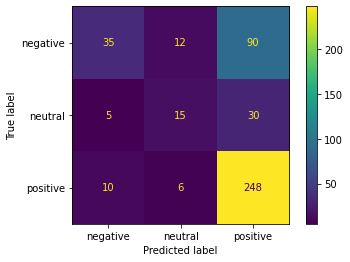

(0.6607538802660754, 0.5068624868389825, 0.6131831153752574)

In [13]:
counter_single = Counter(mvsa_single_multimodal_labels)
print('MVSA-Single:', counter_single)

text_inputs = merge_dim(mvsa_single_bert, mvsa_single_pos_bow)
image_inputs = mvsa_single_vgg19
label_inputs = mvsa_single_multimodal_labels

random_idx = np.random.permutation(len(label_inputs))
text_inputs, image_inputs, label_inputs = text_inputs[random_idx], image_inputs[random_idx], label_inputs[random_idx]

run_and_evaluate_HF('HF-single', text_inputs, image_inputs, label_inputs, verbose=VERBOSE)

MVSA-Multiple: Counter({'positive': 11318, 'neutral': 4407, 'negative': 1299})
              precision    recall  f1-score   support

    negative       0.29      0.41      0.34       118
     neutral       0.65      0.09      0.16       448
    positive       0.72      0.93      0.81      1136

    accuracy                           0.68      1702
   macro avg       0.55      0.48      0.44      1702
weighted avg       0.67      0.68      0.61      1702



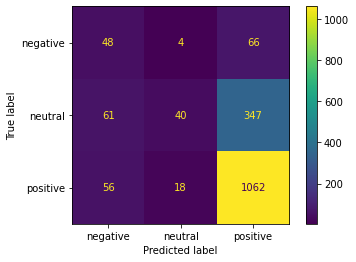

(0.6756756756756757, 0.436522261560169, 0.6077659676036884)

In [14]:
counter_multiple = Counter(mvsa_multiple_multimodal_labels)
print('MVSA-Multiple:', counter_multiple)

text_inputs = merge_dim(mvsa_multiple_bert)
image_inputs = mvsa_multiple_vgg19
label_inputs = mvsa_multiple_multimodal_labels

random_idx = np.random.permutation(len(label_inputs))
text_inputs, image_inputs, label_inputs = text_inputs[random_idx], image_inputs[random_idx], label_inputs[random_idx]

run_and_evaluate_HF('HF-multiple', text_inputs, image_inputs, label_inputs, verbose=VERBOSE)